In [25]:
import pandas, matplotlib.pyplot as plt, geopandas

# NVDI
Inlezen tabel NVDI per perceel, en hieruit alle percelen selecteren met grasland.

In [26]:
df = pandas.read_csv(r'.\data\ndvi_stats_percelen.csv', sep=';', parse_dates=['date_num'])
df_gras = df.loc[df['gewasgroep']=='Grasland']

Bepalen gemiddelde NVDI en aantal datapunten per gemiddelde. Vervolgens wordt de NVDI berekend voor alle datapunten in maart t/m mei

In [27]:
nvdi_mean = df_gras.loc[:,'MEAN'].groupby(df_gras['date_num']).mean()
nvdi_count = df_gras.loc[:,'MEAN'].groupby(df_gras['date_num']).count()

nvdi_mean_voorjaar = nvdi_mean.loc[(nvdi_mean.index.month>=3) & (nvdi_mean.index.month>=5)].mean()

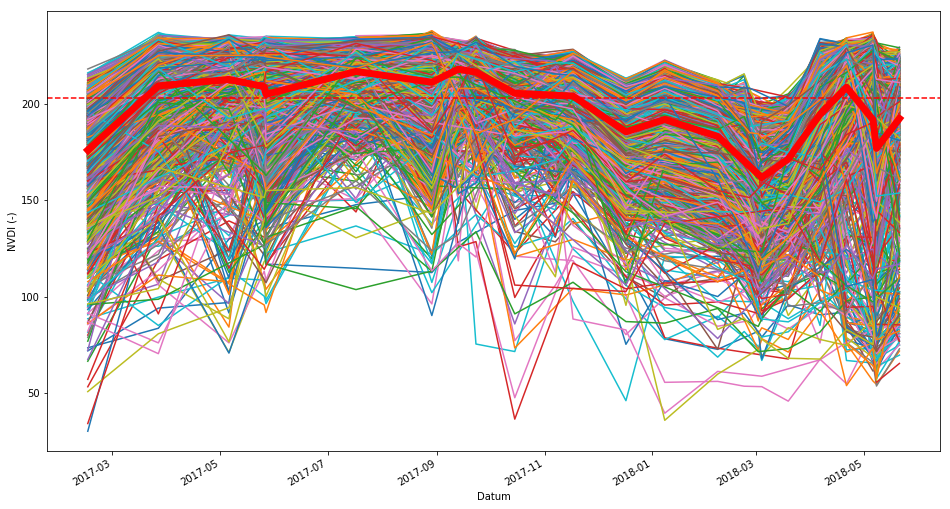

In [28]:
fig, ax = plt.subplots(figsize=[16,9])
for i in df_gras['OBJECTID'].unique():
    y = df_gras.loc[df['OBJECTID']==i]['MEAN']
    x = df_gras.loc[df['OBJECTID']==i]['date_num']
    ax.plot(x, y)
nvdi_mean.loc[nvdi_count>1500].plot(ax=ax, style='r-', linewidth=7.0)
ax.axhline(nvdi_mean_voorjaar, linestyle='--', c='r')
ax.set_ylabel('NVDI (-)')
ax.set_xlabel('Datum');

De maximale NVDI per perceel in de maanden tussen maart en mei en het verschil met het gemiddelde 

In [29]:
df_gras_max_voorjaar = df_gras.loc[(df_gras['month']<=5) & (df_gras['month']>=3), ['MEAN']].groupby(df_gras['OBJECTID']).max()
df_gras_max_voorjaar.columns = ['Max']
df_gras_max_voorjaar['dif'] = df_gras_max_voorjaar['Max']-nvdi_mean_voorjaar
df_gras_max_voorjaar.index.names = ['idx']
df_gras_max_voorjaar['OBJECTID']=df_gras_max_voorjaar.index

Bepalen 25% laagste percelen

In [30]:
nvdi_tresh = df_gras_max_voorjaar['Max'].quantile(0.25)
df_gras_max_voorjaar['tresh'] = (df_gras_max_voorjaar['Max']<=nvdi_tresh).astype(int)

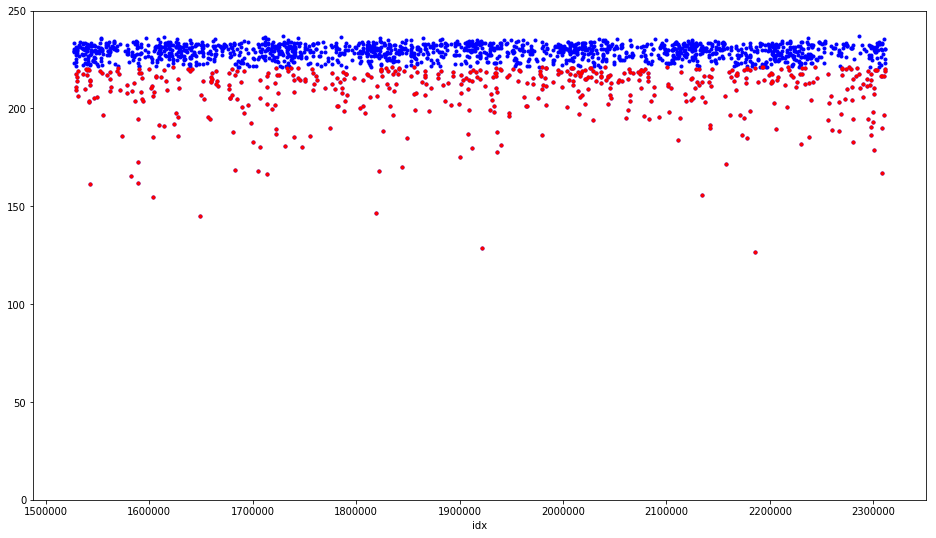

In [31]:
df_gras_max_voorjaar['Max'].plot(figsize=[16,9], style='b.')
df_gras_max_voorjaar.loc[df_gras_max_voorjaar['Max']<nvdi_tresh, 'Max'].plot(figsize=[16,9], style='r.')
plt.ylim(0,250);

# AHN

In [32]:
df_ahn = pandas.read_csv(r'data\AHN2_5m.csv')

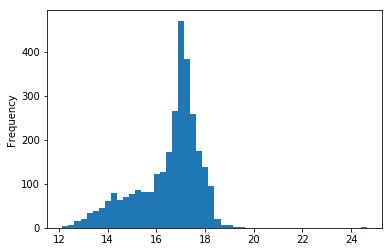

In [33]:
df_ahn['AHN_MEAN'].plot.hist(50)

# Organisch stof

In [138]:
df_os=pandas.read_csv('data\OS_Marke.csv', sep=';')
df_os.index = df_os['OBJECTID']
df_os.index.rename = ['idx']
df_os['mean_os']=df_os.drop(['MarkeID','OBJECTID'], axis=1).mean(axis=1)

# Grondwaterstand

In [139]:
df_gvg=pandas.read_excel(r'data\glg_gvg3_mv.xlsx')

In [140]:
df_gvg=df_gvg.rename(columns={'MEAN': 'MEAN_gvg'})

# Koppelen data aan shape

In [141]:
import geopandas

gdf = geopandas.read_file(r'.\data\gewaspercelen_2017_regio.shp')
gdf = gdf.merge(df_gras_max_voorjaar[['OBJECTID','Max', 'dif', 'tresh']], on='OBJECTID')
gdf = gdf.merge(df_ahn[['OBJECTID', 'AHN_MEAN']], on='OBJECTID')
gdf = gdf.merge(df_gvg[['OBJECTID', 'MEAN_gvg']], on='OBJECTID')
gdf = gdf.merge(df_os[['mean_os','OBJECTID']], on='OBJECTID')
gdf.to_file('results\precelen_nvdi.shp')

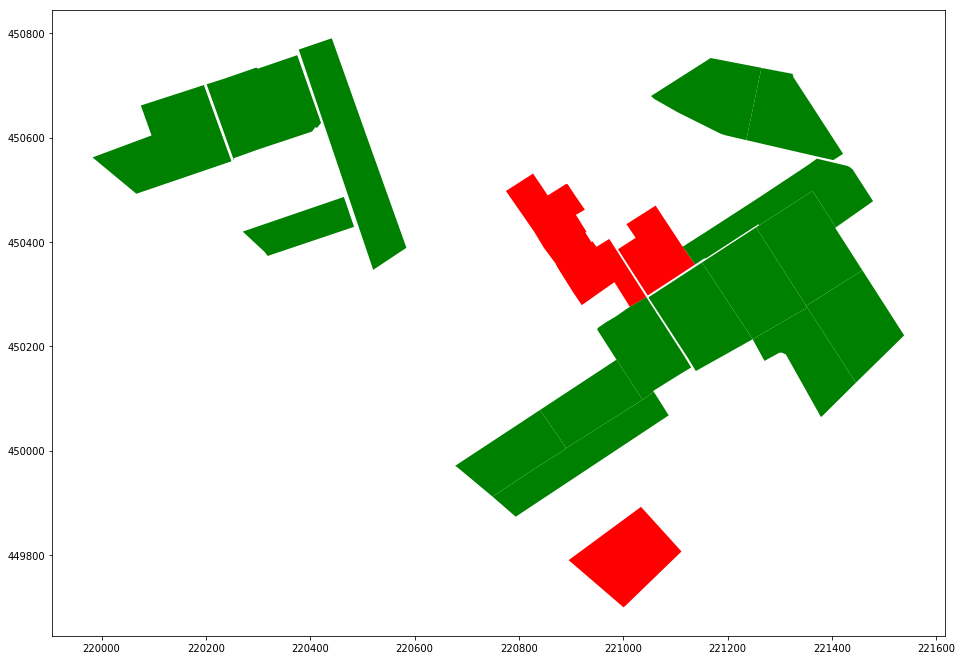

In [142]:
ax = gdf.loc[gdf['tresh']==0].plot(color='g', figsize=[16, 16])
ax = gdf.loc[gdf['tresh']==1].plot(color='r', figsize=[16, 16], ax=ax)

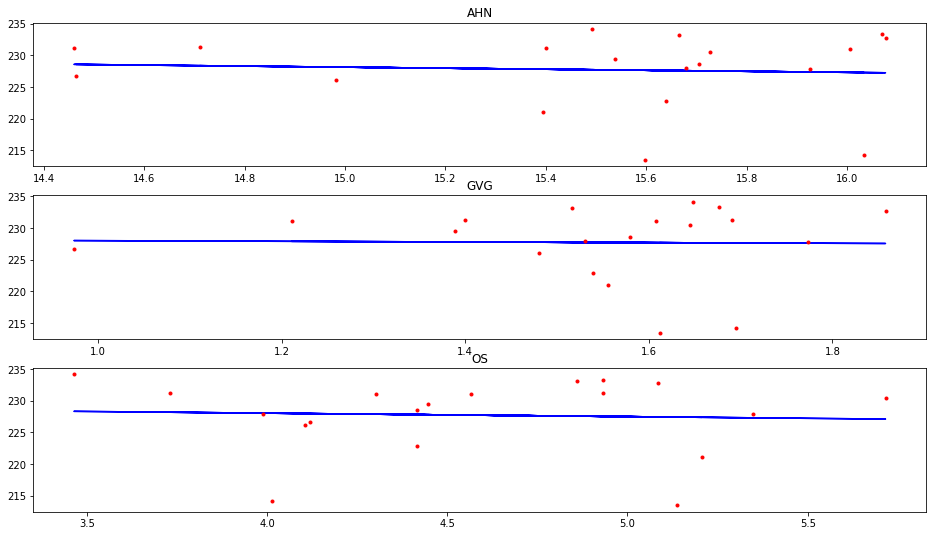

In [144]:
import numpy
fig, ax = plt.subplots(3, figsize=[16,9])
x,y=gdf['AHN_MEAN'], gdf['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[0].plot(x, m*x+b, 'b-') 
ax[0].plot(x,y,'r.')
ax[0].set_title('AHN')

x,y=gdf['MEAN_gvg'], gdf['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[1].plot(x, m*x+b, 'b-') 
ax[1].plot(x,y, 'r.')
ax[1].set_title('GVG')

x,y=gdf['mean_os'], gdf['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[2].plot(x, m*x+b, 'b-') 
ax[2].plot(x,y,'r.')
ax[2].set_title('OS');

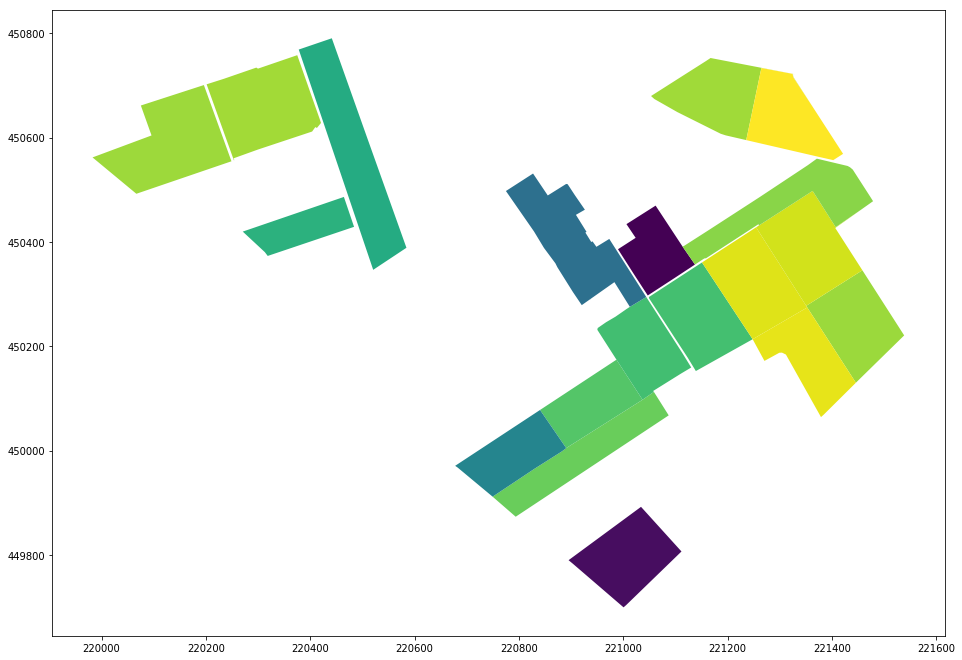

In [145]:
gdf.plot(column='Max', figsize=[16,16])